# Building, Tuning and Selection of  Models


## Business problem:
***Can we create a model that can classify posts from two different subreddits based on their title?***

## What we have done so far?
- Cleaned up our feature which is title to 'preproc_title' (using tokenizer and stemmer)
- created is_nutrition, where 1 means posted under r/Nutrition, and 0 as posted from r/Keto

***is_Nutrition = 1 *** is our positive case

## What are the next steps?

1. Load the data
    - 1.1 Check the base model

2. Define independent(X) and dependent(y)  variable.
    - 2.1 Split our data for training and testing.

3. Define function and dictionary to store parameters and results from building the model

4. Building models and tuning
    - 4.1 CountVectorizer and Logistic Regression
    - 4.2 TfidfVectorizer and Logistic Regression
    - 4.3 CountVectorizer and DecisionTree
    - 4.4 CountVectorizer and Naive Bayes    
    - 4.5 CountVectorizer and BaggingClassifier
    - 4.6 CountVectorizer and RandomForest
    - 4.7 CountVectorizer and ADA Boost
    - 4.8 CountVectorizer and Gradient Boost
    - 4.9 VotingClassifier
    - 4.99 CountVectorizer and SVM

5. Model Evaluation
    - 5.1 Score or Accuracy
    - 5.2 Other Metrics ( Sensitivity, Specificity, Precision, F1 Score)

6. Challenges
     - 6.1 Overfitting Problem

7. Selecting our Best Model
    - 7.1 MODEL SELECTION
    
8. AUC-ROC Curve

9. POST MODEL ANALYSIS
    - 9.1 Distribution of True Value (Y value) and the Prediction (probability)
    - 9.2 Confusion Matrix

10. Deep dive in misclassified posts

11. Coef_

12. Summary and Recommendation

In [1]:
#import our packages here
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_roc_curve, plot_confusion_matrix

#not used, we used manual calculation
#accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression


#cv, tfidf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


#decision tree
from sklearn.tree import DecisionTreeClassifier

#naivebayes
from sklearn.naive_bayes import MultinomialNB


#bagging
from sklearn.ensemble import BaggingClassifier

#random forest
from sklearn.ensemble import RandomForestClassifier


#boosting
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier

#svm
from sklearn.svm import LinearSVC, SVC

#set our width to 500, since title are a bit long
pd.options.display.max_colwidth = 500

In [2]:
#do not show warnings
import warnings
warnings.filterwarnings('ignore')

### 1.0 Load the preprocessed and combined dataset

In [3]:
#load the data for both datasets
df_subr = pd.read_csv("../datasets/combined_subr.csv")

In [4]:
#check the shape of the datasets
print("Keto & Nutrition", df_subr.shape)

Keto & Nutrition (3834, 17)


In [5]:
#check for null values
print(df_subr.isnull().sum().sum())


0


### 1.1 Baseline Model 

Our baseline model is 50%, it means that without any models, if we assign all post to Nutrition (1 as positive case), we then have  50% probability of being accurate.

In [6]:
#distribution
df_subr["is_nutrition"].value_counts()

1    1920
0    1914
Name: is_nutrition, dtype: int64

In [7]:
#baseline model
df_subr["is_nutrition"].value_counts(normalize=True)

1    0.500782
0    0.499218
Name: is_nutrition, dtype: float64

### 2.0 Define X, Y

In [8]:
X = df_subr["preproc_title"]
y = df_subr["is_nutrition"]

### 2.1 Split the Data

In [9]:
#we use stratify=y to balance the distribution for both class
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)

In [10]:
print(X_train.shape, X_test.shape)

(2875,) (959,)


In [11]:
#check the distribution
y.value_counts(normalize=True)

1    0.500782
0    0.499218
Name: is_nutrition, dtype: float64

### 3.0 Defining pipeline and parametes

In [12]:
#we will store all our data in a dictionary for easy storage and access
#includes model pipeline, parameters, and results

#initialize the dictionary
models = {}

#our model's main keys
model_list = ["CVEC", "TVEC", "DTREE", "NB", "BAG", "RF", "ADA", "GB", "VC", "SVC"]


for model in model_list:
    models[model] = {}

# ******PIPELINES****** #

#Logistic Regression with CountVectorizer
models["CVEC"]["pipe"] = [
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())]


#Logistic Regression with TfidfVectorizer
models["TVEC"]["pipe"] = [
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression()) ]


#DecisionTree
models["DTREE"]["pipe"] = [
    ('cvec', CountVectorizer()),
    ('dt', DecisionTreeClassifier()) ]

#NaiveBayes
models["NB"]["pipe"] = [
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB()) ]

#bagging
models["BAG"]["pipe"] = [
    ('cvec', CountVectorizer()),
    ('bag', BaggingClassifier(base_estimator=DecisionTreeClassifier())) ]

#RandomForest
models["RF"]["pipe"] = [
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier()) ]

#ADA
models["ADA"]["pipe"] = [
    ('cvec', CountVectorizer()),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier())) ]

#Gradient Boosting
models["GB"]["pipe"] = [
    ('cvec', CountVectorizer()),
    ('gb', GradientBoostingClassifier()) ]



#SVM
models["SVC"]["pipe"] = [
    ('cvec', CountVectorizer()),
    ('svm', SVC() )]

### 3.1 Function to build the model

In [13]:
def build_model(model, withGridSearch=False):
    
    '''build the model, use the pipeline and paratemer from the model dictionary
    pass the model name as initialized in model_list{}
    withGridSearch=False (will fit using the pipeline only)
    withGridSearch=True (will use the GridSearch and hyperparameters)
    '''
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print(f"Building Model.. {model}   Current Time = {current_time}")

    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    
    if withGridSearch:
        gsearch = "gridsearch"
    else:
        gsearch = "no_gridsearch"
        
    models[model][gsearch] = {}
    
    pipeL = Pipeline(models[model]["pipe"])
    
    if withGridSearch:
         gs = GridSearchCV(pipeL, models[model]["params"], cv=kfold)
    else:
        gs = pipeL
 
    gs.fit(X_train, y_train)
    
    
    #add information on best params and score
    models[model][gsearch]["train_score"] = gs.score(X_train, y_train)
    models[model][gsearch]["test_score"] = gs.score(X_test, y_test)
    models[model][gsearch]["model"] = gs
    
    if withGridSearch:
        models[model][gsearch]["best_params_"] = gs.best_params_
    else:
        models[model][gsearch]["best_params_"] = "n/a"

    predictions = models[model][gsearch]["model"].predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    
    #calculation if we use the package from the metrics, but it's no fun, right?
    
    #recall = recall_score(y_test, predictions)
    #precision = precision_score(y_test, predictions)
    #f1 = f1_score(y_test, predictions)
    
    #let's calculate by hand
    sensitivity = tp / (tp + fn) 
    specificity = tn / (tn + fp)
    precision =  tp / (tp + fp)
    f1_score = 2 * ((precision * sensitivity) / (precision + sensitivity))
    
    
    models[model][gsearch]["sensitivity"] = sensitivity
    models[model][gsearch]["specificity"] = specificity
    models[model][gsearch]["precision"] =  precision
    models[model][gsearch]["f1_score"] = f1_score
    
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print(f"Model Completion.. {model}   Current Time = {current_time}")

## 4. Building and Tuning the MODELS

### 4.1 CountVectorizer and Logistic Regression
***CountVectorizer*** transform Title into a bag of words (in a simple term), or a vector on the basis of the frequency or count of each word that occurs in the entire Title (as a technical description)

In [14]:
#build with default parameter

build_model("CVEC", withGridSearch=False)
display(models["CVEC"]["no_gridsearch"])

Building Model.. CVEC   Current Time = 19:08:03
Model Completion.. CVEC   Current Time = 19:08:03


{'train_score': 0.9485217391304348,
 'test_score': 0.8143899895724713,
 'model': Pipeline(steps=[('cvec', CountVectorizer()), ('lr', LogisticRegression())]),
 'best_params_': 'n/a',
 'sensitivity': 0.8416666666666667,
 'specificity': 0.7870563674321504,
 'precision': 0.7984189723320159,
 'f1_score': 0.8194726166328601}

#### Hyperparametes -- CountVectorizer (from sklearn)

from sklearn:
***max_df*** default=1.0
When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). 
If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

***min_df**  default=1
When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

***max_features*** default=None
If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.



In [15]:
#tuning with hyperparameters
models["CVEC"]["params"] = {
    'cvec__stop_words':[None, "english"],
    'cvec__max_features': [2000,3000,4000,10000],
    'cvec__min_df': [1, 2,3,],
    'cvec__ngram_range' : [(1,1), (1,2),(2,2)],
    'cvec__max_df': [0.1, 0.2, 0.3],
}

build_model("CVEC", True)
display(models["CVEC"]["gridsearch"])

Building Model.. CVEC   Current Time = 19:08:03
Model Completion.. CVEC   Current Time = 19:08:59


{'train_score': 0.9763478260869565,
 'test_score': 0.8133472367049009,
 'model': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                        ('lr', LogisticRegression())]),
              param_grid={'cvec__max_df': [0.1, 0.2, 0.3],
                          'cvec__max_features': [2000, 3000, 4000, 10000],
                          'cvec__min_df': [1, 2, 3],
                          'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                          'cvec__stop_words': [None, 'english']}),
 'best_params_': {'cvec__max_df': 0.2,
  'cvec__max_features': 10000,
  'cvec__min_df': 1,
  'cvec__ngram_range': (1, 2),
  'cvec__stop_words': 'english'},
 'sensitivity': 0.8229166666666666,
 'specificity': 0.8037578288100209,
 'precision': 0.8077709611451943,
 'f1_score': 0.8152734778121775}

*Looks like our model with default parameters is slighly better (and faster) than the GridSearch model* We also notice overfitting, as the train score is over 90% and test score is below 80%

### 4.2 TfidfVectorizer and Logistic Regression

***TfidfVectorizer*** multiplies two metrics: (1) how many times a word appears in a document (2) the inverse document frequency of the word across a set of documents

In [16]:
#build with default parameter
build_model("TVEC", withGridSearch=False)
display(models["TVEC"]["no_gridsearch"])

Building Model.. TVEC   Current Time = 19:08:59
Model Completion.. TVEC   Current Time = 19:08:59


{'train_score': 0.9144347826086957,
 'test_score': 0.8112617309697602,
 'model': Pipeline(steps=[('tvec', TfidfVectorizer()), ('lr', LogisticRegression())]),
 'best_params_': 'n/a',
 'sensitivity': 0.88125,
 'specificity': 0.7411273486430062,
 'precision': 0.773308957952468,
 'f1_score': 0.8237585199610516}

In [17]:
#check valid parameters that we can define
tf = TfidfVectorizer()
tf.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [18]:
#tuning with hyperparameters, min_df, max_df is the same definition as CountVectorizer

models["TVEC"]["params"] =  {
    "tvec__max_features" : [4000,5000],
    "tvec__ngram_range" : [(1,1), (1,2),(2,2)],
    "tvec__stop_words" : [None, "english"],
    'tvec__min_df':[1,2, 3],
    'tvec__max_df': [0.1, 0.2, 0.3],
}


build_model("TVEC", True)
display(models["TVEC"]["gridsearch"])

Building Model.. TVEC   Current Time = 19:08:59
Model Completion.. TVEC   Current Time = 19:09:24


{'train_score': 0.9060869565217391,
 'test_score': 0.8175182481751825,
 'model': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                        ('lr', LogisticRegression())]),
              param_grid={'tvec__max_df': [0.1, 0.2, 0.3],
                          'tvec__max_features': [4000, 5000],
                          'tvec__min_df': [1, 2, 3],
                          'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                          'tvec__stop_words': [None, 'english']}),
 'best_params_': {'tvec__max_df': 0.2,
  'tvec__max_features': 4000,
  'tvec__min_df': 3,
  'tvec__ngram_range': (1, 2),
  'tvec__stop_words': None},
 'sensitivity': 0.8875,
 'specificity': 0.7473903966597077,
 'precision': 0.7787934186471663,
 'f1_score': 0.8296007789678675}

*Tuning the ***TfidfVectorizer*** model is slightly better. The score is also higher than the ***CountVectorizer***.* There is also evidence of  overfitting for both models, as the train score is over 90% and test score is around 81-82%%

### 4.3 CountVectorizer and DecisionTree

***DecisionTree*** The classification process is easy to visualize and understand. It uses a set of rules to make decisions. Just like a flowchart diagram with the terminal nodes representing classification or decisions. Starting with a dataset, you can measure the entropy to find a way to split the set until all the data belongs to the same class. 

*Note on Decision Tree: default parameters (as per sklearn documentation)*
- The default values for the parameters controlling the size of the trees (e.g. max_depth, min_samples_leaf, etc.) lead to fully grown and unpruned trees which can potentially be very large on some data sets. To reduce memory consumption, the complexity and size of the trees should be controlled by setting those parameter values.

In [19]:
#build with default parameter

build_model("DTREE", withGridSearch=False)
display(models["DTREE"]["no_gridsearch"])

Building Model.. DTREE   Current Time = 19:09:24
Model Completion.. DTREE   Current Time = 19:09:24


{'train_score': 0.9982608695652174,
 'test_score': 0.7570385818561001,
 'model': Pipeline(steps=[('cvec', CountVectorizer()), ('dt', DecisionTreeClassifier())]),
 'best_params_': 'n/a',
 'sensitivity': 0.7479166666666667,
 'specificity': 0.7661795407098121,
 'precision': 0.7622080679405521,
 'f1_score': 0.7549947423764458}

#### Hyperparameters - DecisionTreeClassifier (from sklearn)

***max_depth***, default=None
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

***min_samples_split***, default=2
The minimum number of samples required to split an internal node:


***min_samples_leaf*** , default=1
The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

***ccp_alpha***, default=0.0
Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. By default, no pruning is performed. 

In [20]:
#tuning with hyperparameters    
models["DTREE"]["params"]  = {
    #cvec__ parameters here comes from the best_params_ from the GridSearch
    'cvec__max_df': [0.2],
    'cvec__max_features': [10000],
    'cvec__min_df': [1],
    'cvec__ngram_range': [(1, 2)],
    'cvec__stop_words': ['english'],
    #DecisionTree parameter
    'dt__random_state':[0],
    'dt__max_depth':[100, 125, 150], 
    'dt__min_samples_split': [25,50,100],
    'dt__min_samples_leaf': [2, 3,4],
    'dt__ccp_alpha' : [0.01, 0]
}
build_model("DTREE", True)
display(models["DTREE"]["gridsearch"])

Building Model.. DTREE   Current Time = 19:09:24
Model Completion.. DTREE   Current Time = 19:09:49


{'train_score': 0.8490434782608696,
 'test_score': 0.7758081334723671,
 'model': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                        ('dt', DecisionTreeClassifier())]),
              param_grid={'cvec__max_df': [0.2], 'cvec__max_features': [10000],
                          'cvec__min_df': [1], 'cvec__ngram_range': [(1, 2)],
                          'cvec__stop_words': ['english'],
                          'dt__ccp_alpha': [0.01, 0],
                          'dt__max_depth': [100, 125, 150],
                          'dt__min_samples_leaf': [2, 3, 4],
                          'dt__min_samples_split': [25, 50, 100],
                          'dt__random_state': [0]}),
 'best_params_': {'cvec__max_df': 0.2,
  'cvec__max_features': 10000,
  'cvec__min_df': 1,
  'cvec__ngram_range': (1, 2),
  'cvec__stop_words': 'english',
  'dt__ccp_alpha': 0,
  'dt__max

*GridSearch model is not overfitting as much as the model with default parameter and has higher score as well.

### 4.3 Naive Bayes
***Naive Bayes*** methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.

***MultinomialNB*** implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice)

In [21]:
#build with default parameter
build_model("NB", withGridSearch=False)
display(models["NB"]["no_gridsearch"])

Building Model.. NB   Current Time = 19:09:49
Model Completion.. NB   Current Time = 19:09:49


{'train_score': 0.9053913043478261,
 'test_score': 0.8070907194994786,
 'model': Pipeline(steps=[('cvec', CountVectorizer()), ('nb', MultinomialNB())]),
 'best_params_': 'n/a',
 'sensitivity': 0.8604166666666667,
 'specificity': 0.7536534446764092,
 'precision': 0.7777777777777778,
 'f1_score': 0.8170128585558853}

In [22]:
models["NB"]["params"] =  {
                          'nb__fit_prior': [True, False],
                          'nb__alpha': [0, 0.4, 0.8]
                    }

#build with hyperparameter
build_model("NB", withGridSearch=True)
display(models["NB"]["gridsearch"])

Building Model.. NB   Current Time = 19:09:49
Model Completion.. NB   Current Time = 19:09:50


{'train_score': 0.9092173913043479,
 'test_score': 0.8112617309697602,
 'model': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                        ('nb', MultinomialNB())]),
              param_grid={'nb__alpha': [0, 0.4, 0.8],
                          'nb__fit_prior': [True, False]}),
 'best_params_': {'nb__alpha': 0.8, 'nb__fit_prior': False},
 'sensitivity': 0.85,
 'specificity': 0.7724425887265136,
 'precision': 0.7891682785299806,
 'f1_score': 0.8184553660982948}

*NaiveBayes using GridSearch performs better, the overfitting improved as well using GridSearch.*

### 4.5 CountVectorizer and BaggingClassifier
***BaggingClassifier***  is a bootstrap aggregating.
***Bootstrapping*** means random resampling with replacement. 
Bagging (bootstrap aggregating) mitigates the overfitting problem by exposing different trees to different sub-samples of the training set.


In [23]:
#build with default parameter
build_model("BAG", withGridSearch=False)
display(models["BAG"]["no_gridsearch"])

Building Model.. BAG   Current Time = 19:09:50
Model Completion.. BAG   Current Time = 19:09:50


{'train_score': 0.9735652173913043,
 'test_score': 0.7726798748696558,
 'model': Pipeline(steps=[('cvec', CountVectorizer()),
                 ('bag',
                  BaggingClassifier(base_estimator=DecisionTreeClassifier()))]),
 'best_params_': 'n/a',
 'sensitivity': 0.74375,
 'specificity': 0.8016701461377871,
 'precision': 0.7898230088495575,
 'f1_score': 0.7660944206008583}

In [24]:
#just checkign what are valid hyperparameters for BaggingClassifier
bg = BaggingClassifier()
bg.get_params().keys()

dict_keys(['base_estimator', 'bootstrap', 'bootstrap_features', 'max_features', 'max_samples', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

#### Hyperparameters - BaggingClassfier (from sklearn)

***n_estimators***, default=10
The number of base estimators in the ensemble.

***max_samples***, default=1.0
The number of samples to draw from X to train each base estimator (with replacement by default)

***max_features***, default=1.0
The number of features to draw from X to train each base estimator ( without replacement by default, see bootstrap_features for more details).


In [25]:
#tuning with hyperparameters

models["BAG"]["params"]  ={    
    #**cvec__ parameters here comes from the best_params_ from the GridSearch, 
    #**however, the data is performing poorly so might as well use the default value
    
    #'cvec__max_df': [0.2],
    #'cvec__max_features': [10000],
    #'cvec__min_df': [1],
    #'cvec__ngram_range': [(1, 2)],
    #'cvec__stop_words': ['english'],
    
    #RandomForest parameter
    'bag__random_state':[0],   
    'bag__n_estimators' : [200,300],
    'bag__max_features' : [1000,2000],
    'bag__max_samples' : [2000],
    'bag__base_estimator' : [DecisionTreeClassifier()]
}
    
build_model("BAG", True)
display(models["BAG"]["gridsearch"])



Building Model.. BAG   Current Time = 19:09:50
Model Completion.. BAG   Current Time = 19:12:07


{'train_score': 0.9878260869565217,
 'test_score': 0.8237747653806048,
 'model': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                        ('bag',
                                         BaggingClassifier(base_estimator=DecisionTreeClassifier()))]),
              param_grid={'bag__base_estimator': [DecisionTreeClassifier()],
                          'bag__max_features': [1000, 2000],
                          'bag__max_samples': [2000],
                          'bag__n_estimators': [200, 300],
                          'bag__random_state': [0]}),
 'best_params_': {'bag__base_estimator': DecisionTreeClassifier(),
  'bag__max_features': 1000,
  'bag__max_samples': 2000,
  'bag__n_estimators': 300,
  'bag__random_state': 0},
 'sensitivity': 0.8125,
 'specificity': 0.8350730688935282,
 'precision': 0.8315565031982942,
 'f1_score': 0.8219178082191781}

*Both models are overfitting. The tuned model has performed much better in all metrics compared to the model with default parameter, looks like defining our hyperparameters worked positively. 

### 4.6 CountVectorizer and RandomForest
***RandomForest*** uses ensemble method – combine multiple decision trees to predict an outcome.. 

Random forests differ from bagging decision trees in only one way: they use a modified tree learning algorithm that selects, at each split in the learning process, a random subset of the features. This process is sometimes called the random subspace method.

The reason for doing this is the correlation of the trees in an ordinary bootstrap sample: if one or a few features are very strong predictors for the response variable (target output), these features will be used in many/all of the bagged decision trees, causing them to become correlated. By selecting a random subset of features at each split, we counter this correlation between base trees, strengthening the overall model.

In [26]:
#build with default parameter
build_model("RF", withGridSearch=False)
display(models["RF"]["no_gridsearch"])

Building Model.. RF   Current Time = 19:12:07
Model Completion.. RF   Current Time = 19:12:08


{'train_score': 0.9982608695652174,
 'test_score': 0.8091762252346194,
 'model': Pipeline(steps=[('cvec', CountVectorizer()), ('rf', RandomForestClassifier())]),
 'best_params_': 'n/a',
 'sensitivity': 0.8,
 'specificity': 0.8183716075156576,
 'precision': 0.8152866242038217,
 'f1_score': 0.8075709779179812}

#### Hyperparameters - RandomForestClassifier (from sklearn)

***n_estimators***, default=100
The number of trees in the forest.

***max_depth***, default=None
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

In [27]:
#tuning with hyperparameters

models["RF"]["params"]  ={

    #RandomForest parameter
    'rf__n_estimators' : [50, 75, 100],
    'rf__max_depth' : [None, 1, 2,4,6],
    'rf__random_state': [0]
    
}

build_model("RF", True)
display(models["RF"]["gridsearch"])



Building Model.. RF   Current Time = 19:12:08
Model Completion.. RF   Current Time = 19:12:22


{'train_score': 0.9982608695652174,
 'test_score': 0.8008342022940563,
 'model': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                        ('rf', RandomForestClassifier())]),
              param_grid={'rf__max_depth': [None, 1, 2, 4, 6],
                          'rf__n_estimators': [50, 75, 100],
                          'rf__random_state': [0]}),
 'best_params_': {'rf__max_depth': None,
  'rf__n_estimators': 100,
  'rf__random_state': 0},
 'sensitivity': 0.8,
 'specificity': 0.8016701461377871,
 'precision': 0.8016701461377871,
 'f1_score': 0.8008342022940563}

*Both RandomForest models were also showing overfitting, there is no improvement in the model's score after tuning with hyperparameters.

*Bagging Classifier seems to get better score than RandomForest.*


### 4.7 CountVectorizer and ADA Boost
***Boosting*** is a method of converting weak learners into strong learners.  Boosting takes a weak base learner and tries to make it a strong learner by retraining it on the misclassified samples.

ADA Boost or Adaptive Boosting helps combine multiple weak classifier into a single strong classifier.
It fits a sequence of weak learners on different weighted training data. It starts by predicting original data set and gives equal weight to each observation. If prediction is incorrect using the first learner, then it gives higher weight to observation which have been predicted incorrectly. Being an iterative process, it continues to add learner(s) until a limit is reached in the number of models or accuracy.

In [28]:
#build with default parameter
build_model("ADA", withGridSearch=False)
display(models["ADA"]["no_gridsearch"])

Building Model.. ADA   Current Time = 19:12:22
Model Completion.. ADA   Current Time = 19:12:22


{'train_score': 0.9982608695652174,
 'test_score': 0.7632950990615224,
 'model': Pipeline(steps=[('cvec', CountVectorizer()),
                 ('ada',
                  AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))]),
 'best_params_': 'n/a',
 'sensitivity': 0.7770833333333333,
 'specificity': 0.7494780793319415,
 'precision': 0.7565922920892495,
 'f1_score': 0.7667009249743063}

#### Hyperparameters - AdaBoostClassifier (from sklearn)

***base_estimator*** default=None
The base estimator from which the boosted ensemble is built. Support for sample weighting is required, as well as proper classes_ and n_classes_ attributes. If None, then the base estimator is DecisionTreeClassifier initialized with max_depth=1.

***n_estimators***, default=50
The maximum number of estimators at which boosting is terminated. In case of perfect fit, the learning procedure is stopped early.

***learning_rate***, default=1.0
Weight applied to each classifier at each boosting iteration. A higher learning rate increases the contribution of each classifier. There is a trade-off between the learning_rate and n_estimators parameters.


In [29]:
#tuning with hyperparameters
models["ADA"]["params"]  = {  

    #ADA Boosting parameter
    'ada__n_estimators' : [500,1000,4000],
    'ada__learning_rate' : [0.8, 0.5, 0.2, 0.1],
    'ada__base_estimator__max_depth' : [1, 2], 
    'ada__random_state': [0]
}

build_model("ADA", True)
display(models["ADA"]["gridsearch"])

Building Model.. ADA   Current Time = 19:12:22
Model Completion.. ADA   Current Time = 19:56:25


{'train_score': 0.8775652173913043,
 'test_score': 0.8164754953076121,
 'model': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                        ('ada',
                                         AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))]),
              param_grid={'ada__base_estimator__max_depth': [1, 2],
                          'ada__learning_rate': [0.8, 0.5, 0.2, 0.1],
                          'ada__n_estimators': [500, 1000, 4000],
                          'ada__random_state': [0]}),
 'best_params_': {'ada__base_estimator__max_depth': 1,
  'ada__learning_rate': 0.1,
  'ada__n_estimators': 1000,
  'ada__random_state': 0},
 'sensitivity': 0.8333333333333334,
 'specificity': 0.7995824634655533,
 'precision': 0.8064516129032258,
 'f1_score': 0.819672131147541}

*The model using GridSearch is performing a much better than the default parameter. Overfitting is minimized in the model with hyperparameters*

### 4.8 CountVectorizer and Gradient Boost
- In ***gradient boosting***, it trains many model sequentially. Each new model gradually minimizes the loss function (y = ax + b + e, e needs special attention as it is an error term) of the whole system using Gradient Descent method. The learning procedure consecutively fit new models to provide a more accurate estimate of the response variable.

In [30]:
#build with default parameter
build_model("GB", withGridSearch=False)
display(models["GB"]["no_gridsearch"])

Building Model.. GB   Current Time = 19:56:25
Model Completion.. GB   Current Time = 19:56:25


{'train_score': 0.798608695652174,
 'test_score': 0.7539103232533889,
 'model': Pipeline(steps=[('cvec', CountVectorizer()),
                 ('gb', GradientBoostingClassifier())]),
 'best_params_': 'n/a',
 'sensitivity': 0.95625,
 'specificity': 0.5511482254697286,
 'precision': 0.6810089020771514,
 'f1_score': 0.7954939341421144}

#### Hyperparameters - GradientBoostClassifier (from sklearn)


***learning_rate***, default=0.1
Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.

***n_estimators***, default=100
The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.

***max_depth***, default=3
The maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. Tune this parameter for best performance; the best value depends on the interaction of the input variables.

In [31]:
#tuning with hyperparameters

models["GB"]["params"]  = {
    "gb__max_depth" : [4, 6,8],
    "gb__n_estimators" : [500,600,800],
    "gb__learning_rate" : [0.8, 0.10, 0.12],
    "gb__random_state": [0]
}


build_model("GB", True)
display(models["GB"]["gridsearch"])

Building Model.. GB   Current Time = 19:56:25
Model Completion.. GB   Current Time = 20:01:45


{'train_score': 0.9721739130434782,
 'test_score': 0.8269030239833159,
 'model': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                        ('gb', GradientBoostingClassifier())]),
              param_grid={'gb__learning_rate': [0.8, 0.1, 0.12],
                          'gb__max_depth': [4, 6, 8],
                          'gb__n_estimators': [500, 600, 800],
                          'gb__random_state': [0]}),
 'best_params_': {'gb__learning_rate': 0.1,
  'gb__max_depth': 4,
  'gb__n_estimators': 600,
  'gb__random_state': 0},
 'sensitivity': 0.86875,
 'specificity': 0.7849686847599165,
 'precision': 0.801923076923077,
 'f1_score': 0.834}

*The model using GridSearch is performing much better than the default parameter. Overfitting is also a problem in Gridsearch model.

### 4.9 VotingClassifier
A ***Voting Classifier*** also trains on an ensemble of numerous models and predicts an output based on their highest probability of chosen class as the output.

It simply aggregates the findings of each classifier passed into Voting Classifier and predicts the output class based on the highest majority of voting. The idea is instead of creating separate dedicated models and finding the accuracy for each them, we create a single model which trains by these models and predicts output based on their combined majority of voting for each output class.

Hard Voting: In hard voting, the predicted output class is a class with the highest majority of votes
Soft Voting: In soft voting, the output class is the prediction based on the average of probability given to that class. 

In [32]:
cvec = CountVectorizer()
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)
vote = VotingClassifier([
    ("tree", DecisionTreeClassifier(random_state= 0)),
    ('ada', AdaBoostClassifier(learning_rate= 0.1, n_estimators= 1000,  random_state= 0)),
    ('gb', GradientBoostingClassifier(learning_rate =  0.12, max_depth = 6,n_estimators = 500,random_state= 0))
])


In [33]:
vote.fit(X_train_cvec, y_train)

VotingClassifier(estimators=[('tree', DecisionTreeClassifier(random_state=0)),
                             ('ada',
                              AdaBoostClassifier(learning_rate=0.1,
                                                 n_estimators=1000,
                                                 random_state=0)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.12,
                                                         max_depth=6,
                                                         n_estimators=500,
                                                         random_state=0))])

In [34]:
#models["VC"]["best_params_"] = vote.best_params_

models["VC"]["no_gridsearch"] = {}
models["VC"]["no_gridsearch"]["train_score"] = vote.score(X_train_cvec, y_train)
models["VC"]["no_gridsearch"]["test_score"] = vote.score(X_test_cvec, y_test)
models["VC"]["no_gridsearch"]["model"] = vote

predictions = models["VC"]["no_gridsearch"]["model"].predict(X_test_cvec)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
sensitivity = tp / (tp + fn) 
specificity = tn / (tn + fp)
precision =  tp / (tp + fp)
f1_score = 2 * ((precision * sensitivity) / (precision + sensitivity))
    
    
models["VC"]["no_gridsearch"]["sensitivity"] = sensitivity
models["VC"]["no_gridsearch"]["specificity"] = specificity
models["VC"]["no_gridsearch"]["precision"] =  precision
models["VC"]["no_gridsearch"]["f1_score"] = f1_score
    

In [35]:
display(models["VC"]["no_gridsearch"])

{'train_score': 0.984,
 'test_score': 0.8175182481751825,
 'model': VotingClassifier(estimators=[('tree', DecisionTreeClassifier(random_state=0)),
                              ('ada',
                               AdaBoostClassifier(learning_rate=0.1,
                                                  n_estimators=1000,
                                                  random_state=0)),
                              ('gb',
                               GradientBoostingClassifier(learning_rate=0.12,
                                                          max_depth=6,
                                                          n_estimators=500,
                                                          random_state=0))]),
 'sensitivity': 0.8479166666666667,
 'specificity': 0.7870563674321504,
 'precision': 0.7996070726915521,
 'f1_score': 0.8230535894843276}

If we use voting = "soft", we can use the .proba to check the probability, but the default parameter "hard" performs better

### 4.99 CountVectorizer and SVM
***Support Vector Machine*** algorithm separates data points using a hyperplane with the highest amount of margin.The algorithm determines the best decision boundary between vectors that belong to a given category.

In [36]:
#build with default parameter
build_model("SVC", withGridSearch=False)
display(models["SVC"]["no_gridsearch"])

Building Model.. SVC   Current Time = 20:01:50
Model Completion.. SVC   Current Time = 20:01:51


{'train_score': 0.9540869565217391,
 'test_score': 0.7987486965589156,
 'model': Pipeline(steps=[('cvec', CountVectorizer()), ('svm', SVC())]),
 'best_params_': 'n/a',
 'sensitivity': 0.84375,
 'specificity': 0.7536534446764092,
 'precision': 0.7743785850860421,
 'f1_score': 0.8075772681954138}

In [37]:
sv = SVC()
sv.get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

#### Hyperparameters - AdaBoostClassifier (from sklearn)

***C***, default=1.0
Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.

***kernel*** {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
Specifies the kernel type to be used in the algorithm. If none is given, ‘rbf’ will be used. If a callable is given it is used to pre-compute the kernel matrix from data matrices; that matrix should be an array of shape (n_samples, n_samples).

***max_iter***, default=-1
Hard limit on iterations within solver, or -1 for no limit.

***gamma*** {‘scale’, ‘auto’} or float, default=’scale’
Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.



In [38]:
#tuning with hyperparameters
#C is a penalty parameter, which represents misclassification or error term. 
#Gamma is a parameter that influences the calculation of plausible line of separation for SVM. 
#When gamma is higher, nearby points will have high influence in the calculation of the decision boundary. 
#A low gamma means far away points also be considered when calculating the decision boundary.
#Kernel -?

models["SVC"]["params"]  = {  
    #SVC Boosting parameter
    'svm__max_iter' : [-1, 10_000],
    'svm__C' : [0.0001, 0.1, 0.2, 0.3],
    'svm__gamma':[0.1, 0.3], 
    'svm__kernel':['linear','rbf'],
    
}

build_model("SVC", True)
display(models["SVC"]["gridsearch"])

Building Model.. SVC   Current Time = 20:01:51
Model Completion.. SVC   Current Time = 20:02:50


{'train_score': 0.9314782608695652,
 'test_score': 0.8102189781021898,
 'model': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                        ('svm', SVC())]),
              param_grid={'svm__C': [0.0001, 0.1, 0.2, 0.3],
                          'svm__gamma': [0.1, 0.3],
                          'svm__kernel': ['linear', 'rbf'],
                          'svm__max_iter': [-1, 10000]}),
 'best_params_': {'svm__C': 0.2,
  'svm__gamma': 0.1,
  'svm__kernel': 'linear',
  'svm__max_iter': -1},
 'sensitivity': 0.8458333333333333,
 'specificity': 0.7745302713987474,
 'precision': 0.7898832684824902,
 'f1_score': 0.8169014084507042}

* There is slight improvement from the default model vs the tuned model, both models have overfitting problem*

## 5.0 Model Evaluation

### 5.1 Score or Accuracy

***Score or Accuracy means the count the number of matches (prediction vs actual) divided by by the number of samples.***

*In this metrics, our top  model(s) within 82%:*
- GB Test Score: 0.8269
- BAG Test Score: 0.8237


In [39]:
#Models by Score
for model in models:
    if model != 'VC':
        print(f"{model} Test Score: {models[model]['gridsearch']['test_score']}")
    else:
        print(f"{model} Test Score: {models[model]['no_gridsearch']['test_score']}")

CVEC Test Score: 0.8133472367049009
TVEC Test Score: 0.8175182481751825
DTREE Test Score: 0.7758081334723671
NB Test Score: 0.8112617309697602
BAG Test Score: 0.8237747653806048
RF Test Score: 0.8008342022940563
ADA Test Score: 0.8164754953076121
GB Test Score: 0.8269030239833159
VC Test Score: 0.8175182481751825
SVC Test Score: 0.8102189781021898


In [40]:
score_list = []

for model in models:
    if model != 'VC':
        dic = {"model": model,
                "score": models[model]['gridsearch']["test_score"]
        }
        score_list.append(dic)
df_score = pd.DataFrame(score_list)
df_score

,model,score
0,CVEC,0.813347
1,TVEC,0.817518
2,DTREE,0.775808
3,NB,0.811262
4,BAG,0.823775
5,RF,0.800834
6,ADA,0.816475
7,GB,0.826903
8,SVC,0.810219


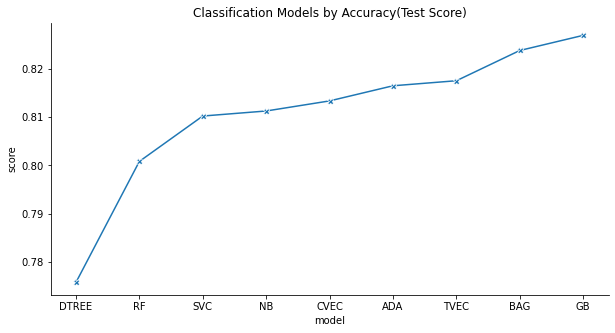

In [41]:
df_score = df_score.sort_values(by="score")

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
sns.lineplot(data=df_score, x='model', y='score', ax=ax, marker='X');

plt.title("Classification Models by Accuracy(Test Score)", fontsize=12)
#plt.ylim(0,0.9)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 


***BaggingClassifier and GradientBoost have the highest accuracy***

### 5.2 OTHER  METRICS

### Sensitivity

***Sensitivity*** is a measure of the proportion of actual positive cases that got predicted as positive (or true positive). Sensitivity is also termed as Recall.

In this project, our ***True Positive*** are those Nutrition that are accurately predicted as Nutrition.  ***False Negative*** means those Nutrition that are predicted as Keto.

Sensitivity = (True Positive)/(True Positive + False Negative)

The higher the Sensitivity Rate means we have captured more on our positive class (Nutrition)

*In this metric, our best model is:*
- TVEC Sensitivity: 0.8875   (88% of Nutrition are predicted accurately)


In [42]:
#Models by sensitivity
for model in models:
    if model != 'VC':
        print(f"{model} Sensitivity Rate: {models[model]['gridsearch']['sensitivity']}")
    else:
        print(f"{model} Sensitivity Rate: {models[model]['no_gridsearch']['sensitivity']}")

CVEC Sensitivity Rate: 0.8229166666666666
TVEC Sensitivity Rate: 0.8875
DTREE Sensitivity Rate: 0.7354166666666667
NB Sensitivity Rate: 0.85
BAG Sensitivity Rate: 0.8125
RF Sensitivity Rate: 0.8
ADA Sensitivity Rate: 0.8333333333333334
GB Sensitivity Rate: 0.86875
VC Sensitivity Rate: 0.8479166666666667
SVC Sensitivity Rate: 0.8458333333333333


### Specificity

***Specificity*** is a measure of the proportion of actual negative cases that got predicted as negative (or true negative). 

In this project, our ***True Negative*** are those Keto titles that are accurately predicted as Keto. ***False Positive*** means those Keto that are predicted as Nutrition title.

Specificity = (True Negative)/(True Negative + False Positive)

The higher the Specificity Rate means we have captured more accurately on our negative class (Keto)

*In this metric, our best models are:*
- BAG Specificity Rate: 0.835  (82% of Keto post are predicted accurately as Keto)


In [43]:
#Models by specificity
for model in models:
    if model != 'VC':
        print(f"{model} Specificity Rate: {models[model]['gridsearch']['specificity']}")
    else:
        print(f"{model} Specificity Rate: {models[model]['no_gridsearch']['specificity']}")

CVEC Specificity Rate: 0.8037578288100209
TVEC Specificity Rate: 0.7473903966597077
DTREE Specificity Rate: 0.8162839248434238
NB Specificity Rate: 0.7724425887265136
BAG Specificity Rate: 0.8350730688935282
RF Specificity Rate: 0.8016701461377871
ADA Specificity Rate: 0.7995824634655533
GB Specificity Rate: 0.7849686847599165
VC Specificity Rate: 0.7870563674321504
SVC Specificity Rate: 0.7745302713987474


### Precision

***Precision***  evaluates the fraction of correctly classified instances or samples among the ones classified as positives.

Precision is the number of true positive results divided by the number of all positive results, including those not identified correctly:
Precision = TP/(TP + FP)

*In this metric, our best models are:*
- BAG Precision: 0.8315


In [44]:
#Models by precision
for model in models:
    if model != 'VC':
        print(f"{model} Precision: {models[model]['gridsearch']['precision']}")
    else:
        print(f"{model} Precision: {models[model]['no_gridsearch']['precision']}")

CVEC Precision: 0.8077709611451943
TVEC Precision: 0.7787934186471663
DTREE Precision: 0.800453514739229
NB Precision: 0.7891682785299806
BAG Precision: 0.8315565031982942
RF Precision: 0.8016701461377871
ADA Precision: 0.8064516129032258
GB Precision: 0.801923076923077
VC Precision: 0.7996070726915521
SVC Precision: 0.7898832684824902


### F1_Score

***F-score or F1 Score*** is a measure of a prediction's accuracy. It is calculated from the precision and recall/sensitivity of the test.

The F1 score is the harmonic mean of precision and recall.
If you care about precision and recall roughly the same amount, F1 score is a great metric to use.

F1_Score = 2 * ((precision * sensitivity) / (precision + sensitivity))


*In this metric, our best model is:*
- GB F1 Score: 0.834

In [45]:
#Models by f1-score
for model in models:
    if model != 'VC':
        print(f"{model} F1 Score: {models[model]['gridsearch']['f1_score']}")
    else:
        print(f"{model} F1 Score: {models[model]['no_gridsearch']['f1_score']}")

CVEC F1 Score: 0.8152734778121775
TVEC F1 Score: 0.8296007789678675
DTREE F1 Score: 0.7665580890336592
NB F1 Score: 0.8184553660982948
BAG F1 Score: 0.8219178082191781
RF F1 Score: 0.8008342022940563
ADA F1 Score: 0.819672131147541
GB F1 Score: 0.834
VC F1 Score: 0.8230535894843276
SVC F1 Score: 0.8169014084507042


## 6. Challenges

### 6.1 Overfitting Problem

***Almost all models have overfitting problems, Train Score has  more than 10% of the Test Score***

In [46]:

overfit_list = []

for model in models:
    if model != 'VC':
        dic = {"model": model,
                          "Score Diff": models[model]['gridsearch']['train_score'] - models[model]['gridsearch']['test_score']
                         }
        overfit_list.append(dic)

df_overfit = pd.DataFrame(overfit_list)

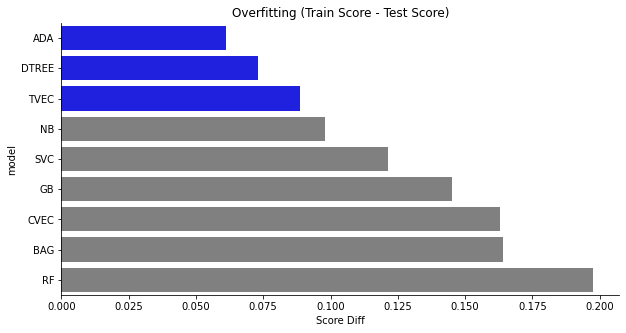

In [72]:
df_overfit = df_overfit.sort_values(by="Score Diff")

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
sns.barplot(data=df_overfit, y='model',x='Score Diff', ax=ax, orient = "h", palette=["blue","blue","blue","gray","gray","gray","gray","gray", "gray"]);

plt.title("Overfitting (Train Score - Test Score)", )
#plt.xlim(0,0.4)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 


***DTREE, ADA, TVDC has below 10% difference from their Train Score, while the rest have difference between 12 to 20%%***


# 7.0 How do we choose our model then? What metrics should we consider to make the decision?


In [48]:
metrics = ['test_score', 'sensitivity', 'f1_score']

to_df = []

for model in models:
    if model in ('BAG', 'GB'):
        for metric in metrics:

            dic = {"model": model,
                          "metric": metric,
                          "value": models[model]['gridsearch'][metric]
                         }
            to_df.append(dic)
df_model = pd.DataFrame(to_df)
df_model

,model,metric,value
0,BAG,test_score,0.823775
1,BAG,sensitivity,0.812500
2,BAG,f1_score,0.821918
3,GB,test_score,0.826903
4,GB,sensitivity,0.868750
5,GB,f1_score,0.834000


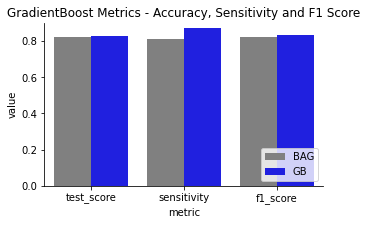

In [49]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
sns.barplot(data=df_model, x='metric', y='value', hue='model', ax=ax, palette=["gray", "blue"]);

plt.title("GradientBoost Metrics - Accuracy, Sensitivity and F1 Score", fontsize=12)
plt.ylim(0,0.9)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 

plt.legend(loc='lower right');

In [50]:
metrics = ['specificity', 'precision']

to_df = []

for model in models:
    if model in ('BAG', 'GB'):
        for metric in metrics:

            dic = {"model": model,
                          "metric": metric,
                          "value": models[model]['gridsearch'][metric]
                         }
            to_df.append(dic)
df_model = pd.DataFrame(to_df)
df_model

,model,metric,value
0,BAG,specificity,0.835073
1,BAG,precision,0.831557
2,GB,specificity,0.784969
3,GB,precision,0.801923


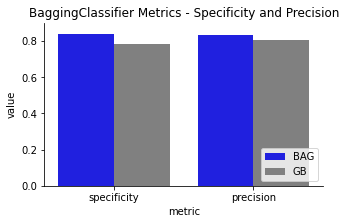

In [51]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
sns.barplot(data=df_model, x='metric', y='value', hue='model', ax=ax, palette=["blue", "gray"]);

plt.title("BaggingClassifier Metrics - Specificity and Precision", fontsize=12)
plt.ylim(0,0.9)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 

plt.legend(loc='lower right');

***Accuracy***
- GradientBoost:  83%

***Sensitivity***
- GradientBoost: 87% of Nutrition are predicted accurately (Positive Class)

***Specificity***
- BaggingClassifier: 84% of Keto post are predicted accurately as Keto (Negative Class)
TFIDFVectorizer 

***Precision***
- BaggingClassifier: 83% 

***F1 Score*** Balance between Sensitivity and Specificity
- GradientBoost: 83%

# 7.1 MODEL SELECTION:

We selected  **Bagging Classifier** as our best  model for this classification project, though ***GradientBoosting*** Classifier tops Accuracy and F1, it wasn’t that much difference. 

The major difference is in Sensitivity and Specificity, we want our negative class to be predicted more accurately, as *Keto* is strict diet and should not be classified under the *Nutrition* subreddit. Bagging Classifier is highest in this metric 83.5% compared to Bagging Classifier with 78.5

I think the distribution of probabilities made a lot of difference too in this decision. As we can further enhance the Sensitivity of the BaggingClassifier by adjusting our decision boundaries. There is a trade-off between getting the best result and the interpretability of the model.

### 8.0 AUC-ROC Curve

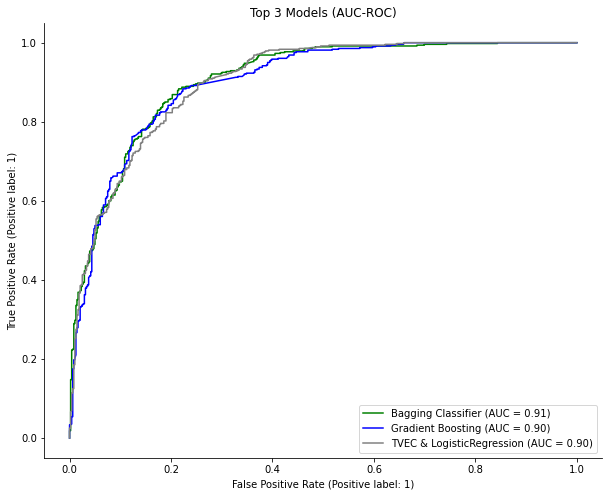

In [52]:
#Visualize ROC
fig, ax = plt.subplots(1, 1, figsize=(10,8))

plot_roc_curve(models["BAG"]["gridsearch"]["model"], X_test, y_test,  ax=ax, name='Bagging Classifier', color='green');
plot_roc_curve(models["GB"]["gridsearch"]["model"], X_test, y_test,  ax=ax, name='Gradient Boosting', color='blue');
plot_roc_curve(models["TVEC"]["gridsearch"]["model"], X_test, y_test,  ax=ax, name='TVEC & LogisticRegression', color='gray');


plt.title('Top 3 Models (AUC-ROC)')
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 



## 9.0 POST MODEL ANALYSIS

### 9.1 Distribution of True Value (Y value) and the Prediction (probability)

In [53]:
bg = models["BAG"]["gridsearch"]["model"]

In [54]:
pred_bg = pd.DataFrame({'true_values': y_test,
                        'pred_probs': bg.predict_proba(X_test)[:,1]})

pred_bg.head()

,true_values,pred_probs
642,0,0.431721
2015,1,0.523950
1725,0,0.322522
1885,0,0.346816
3639,1,0.629416


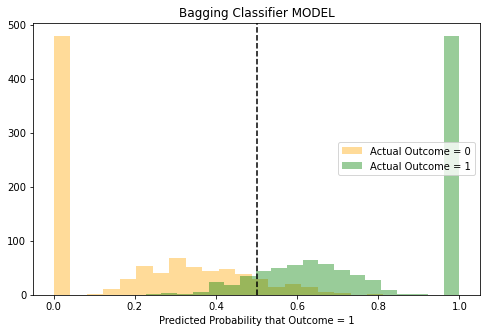

In [92]:
plt.figure(figsize = (8, 5))
color=["orange", "green"]
i = 0
# plot distributions of predicted probabilities by actual values
for group in pred_bg.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}', color=color[i])
    i += 1

# Add cutoff line
plt.axvline(0.5, color='black', linestyle='--')

plt.title("Bagging Classifier MODEL")
plt.xlabel('Predicted Probability that Outcome = 1');
plt.legend(loc="center right");

The orange ones on the left are the Actual post for Keto. If there is no overlap with greens, those are the True Negatives, the model correctly classified as Keto.

The green on the right are the Actual post for Nutrition.If there is no overlap with green, those are the True Positives, where the model correctly classified as Nutrition.

The ovelap however are the False Positives (the green overlapping with orange that goes beyond 50%),  and the False Negatives (the orange that overlaps the green below 50%) .

*You will notice that the distribution in the middle is around the mean, as Bagging is ensemble technique and the score is the average from multiple models. We can also adjust our decision boundary for example to .4 (or probability of 40%) to capture more True Positives increasing our Sensitivity Rate.

In [56]:
gb = models["GB"]["gridsearch"]["model"]

In [57]:
pred_tv = pd.DataFrame({'true_values': y_test,
                        'pred_probs': gb.predict_proba(X_test)[:,1]})

pred_tv.head()

,true_values,pred_probs
642,0,0.336076
2015,1,0.741561
1725,0,0.068244
1885,0,0.379554
3639,1,0.724113


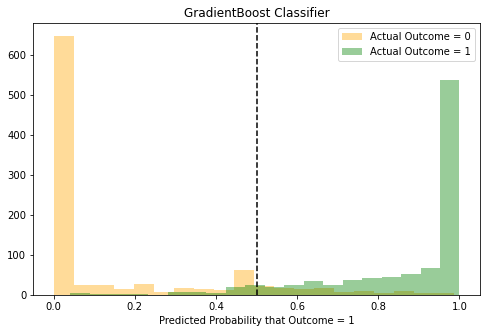

In [87]:
plt.figure(figsize = (8, 5))

color=["orange", "green"]
i = 0

# plot distributions of predicted probabilities by actual values
for group in pred_tv.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}', color=color[i])
    i += 1

# Add cutoff line
plt.axvline(0.5, color='black', linestyle='--')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.title("GradientBoost Classifier");
plt.legend();

*The misclassifications are spread out for GradientBoost. There are many orangecrossing the decision boundary and missclassified as Nutrition*

### 9.2 Confusion Matrix

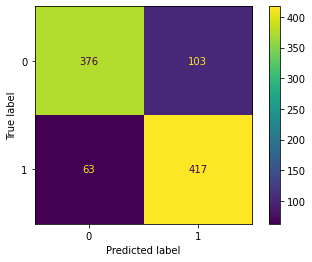

In [59]:
#check the confusion matrix for GradientBoost
plot_confusion_matrix(models['GB']['gridsearch']['model'], X_test, y_test);

In [60]:
predictions = models['GB']['gridsearch']['model'].predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print(tn, fp, fn, tp)

376 103 63 417


###### ***Interpretation of the confusion matrix for GradientBoost***

- True Negative (tn) -> 376 (Actual = Keto  and Predicted = Keto)
- False Positive (fp) - > 103 (Actual = Keto  and Predicted = Nutrition)
- False Negative (fn) -> 63 (Actual = Nutrition  and Predicted = Keto)
- True Positive  (tp) -> 417 (Actual = Nutrition  and Predicted = Nutrition)



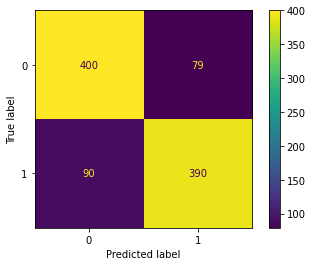

In [61]:
#check the confusion matrix for BaggingClassifier
plot_confusion_matrix(models['BAG']['gridsearch']['model'], X_test, y_test);

In [62]:
predictions = models['BAG']['gridsearch']['model'].predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print(tn, fp, fn, tp)

400 79 90 390


***Interpretation of the confusion matrix for Bagging***

- True Negative (tn) -> 400 (Actual = Keto  and Predicted = Keto)
- False Positive (fp) - > 79 (Actual = Keto  and Predicted = Nutrition)
- False Negative (fn) -> 90 (Actual = Nutrition  and Predicted = Keto)
- True Positive (tp) -> 390 (Actual = Nutrition  and Predicted = Nutrition)


### 10.0 Deep dive in misclassified posts

In [73]:
#let's build a dataframe to look closer of our original data including the model's prediction
##USING BAGGING CLASSIFIER MODEL

predictions = pd.DataFrame(bg.predict_proba(X))
predictions.rename(columns={0: 'Keto', 1: 'Nutrition'}, inplace=True)
predictions['title'] = df_subr['title']

#our actual label
predictions['actual'] = df_subr['is_nutrition']

#the model's prediction
predictions['predict'] = gb.predict(X)


In [74]:
#get all misclassified post
misclass_preds = predictions[ (predictions['actual']!= predictions['predict']) ]
misclass_preds.shape

(246, 5)

In [75]:
misclass_preds.head()

,Keto,Nutrition,title,actual,predict
1,0.597728,0.402272,"The first thing i was served in 2022 was bone broth, in a disco, no less.",0,1
4,0.611615,0.388385,Tomorrow is the big day,0,1
6,0.600783,0.399217,Need help with good,0,1
16,0.631482,0.368518,This is not a new years resolution.,0,1
23,0.554262,0.445738,Cooking for others,0,1


####  False Negative -- posted in "Nutrition" but model wrongly predicted as "Keto"

In [79]:
#let's got some samples with over 80% probability
false_neg = misclass_preds[(misclass_preds['Keto'] > 0.70) & (misclass_preds['actual'] == 1)]

false_neg['actual'] = false_neg['actual'].map(lambda x: 'Nutrition' if x==1 else 'Keto')
false_neg['predict'] = false_neg['predict'].map(lambda x: 'Nutrition' if x==1 else 'Keto')

false_neg

,Keto,Nutrition,title,actual,predict
2439,0.772803,0.227197,the fastest method to lose weight https://shrinke.me/IqwFdwjU,Nutrition,Keto
2521,0.705511,0.294489,New member i need halp,Nutrition,Keto
2928,0.711202,0.288798,"36F with PCOS, trying low carb, intermittent fasting - so tired, how can I fix this?",Nutrition,Keto
3045,0.733230,0.266770,Keto Diet and its health benefits,Nutrition,Keto


***I could understand the wrong prediction, the "keto" is all over the title, and probably the reason it was predicted as negative class***

####  False Positives -- posted in "Nutrition" but model wrongly predicted as "Keto"

In [80]:
#lets get some sample data
false_pos = misclass_preds[(misclass_preds['Nutrition'] > 0.70) & (misclass_preds['actual'] == 0)]

false_pos['actual'] = false_pos['actual'].map(lambda x: 'Nutrition' if x==1 else 'Keto')
false_pos['predict'] = false_pos['predict'].map(lambda x: 'Nutrition' if x==1 else 'Keto')

false_pos

,Keto,Nutrition,title,actual,predict
684,0.187129,0.812871,Great Value chia seeds nutritional info vs other sources of nutritional info,Keto,Nutrition
685,0.298475,0.701525,"For the purpose of blood sugar/insulin regulation, how important is it to eat protein paired with fat/fiber?",Keto,Nutrition
821,0.268927,0.731073,"I'm making chicken teriyaki tomorrow, can someone recommend a side that will complement it well?",Keto,Nutrition
1438,0.297053,0.702947,How many calories should I be consuming daily?,Keto,Nutrition


#### 'Nutrients, Vitamins, Protein' are key words for Nutrition, so they are predicted as Nutrition though they posted under Keto subreddits

### Coef_

Bagging/Boosting doesn't have coef so we will use TVEC. This is one of the trade-off for using more complex models, the interpretability.

In [81]:
#we will use the model for the TFIDFVecotizer to get the coefficients related to Nutrition and Keto
coef = pd.DataFrame(models["TVEC"]["gridsearch"]["model"].best_estimator_.steps[1][1].coef_).T
coef.columns = ['coef']
coef['ngram'] = models["TVEC"]["gridsearch"]["model"].best_estimator_.steps[0][1].get_feature_names()
coef = coef[['ngram','coef']]
coef = coef.sort_values('coef', ascending=False)

In [82]:
top_nutrition_coef = coef.head(15).reset_index(drop=True)
top_keto_coef = coef.tail(15).sort_values(by='coef', ascending=False).reset_index(drop=True)

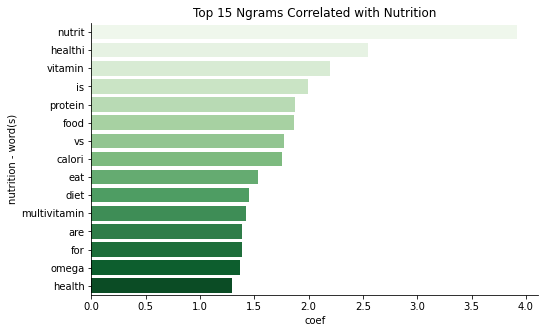

In [83]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

sns.barplot(data=top_nutrition_coef, x='coef', y='ngram', palette='Greens', ax=ax);

ax.set_title("Top 15 Ngrams Correlated with Nutrition", fontsize =12)
ax.set_ylabel('nutrition - word(s)',fontsize=10)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 

plt.show()

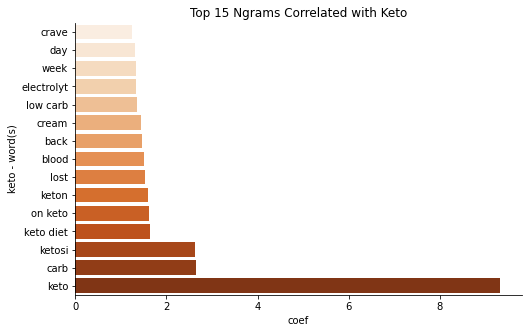

In [84]:

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

sns.barplot(data=top_keto_coef, x=abs(top_keto_coef['coef']), y='ngram', palette='Oranges', ax=ax);

ax.set_title("Top 15 Ngrams Correlated with Keto", fontsize =12)
ax.set_ylabel('keto - word(s)',fontsize=10)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 

plt.show()

# 12.0 Summary:

***To answer our Business Problem: Yes, we have created models and selected the best one that can classify posts from two different subreddits based on the TITLE with 83% Accuracy.***
     
- We selected  ***Bagging Classifier*** as our best  model for this classification project, though GradientBoosting Classifier tops Accuracy and F1, it wasn’t that much difference. The major difference is in Sensitivity and Specificity, we want our negative class to be predicted more accurately, as Keto is strict diet and should not be classified under the Nutrition subreddit. Bagging Classifier is highest in this metric with 83.5% rate compared to Bagging Classifier with only 78.5%
     
## CHALLENGES
- We have observed overfitting in most of the models. This limitation was not overcome by ensemble methods and probably need more tuning on the hyperparameters to achieve better results.

- Time to run GridSearch using hyperparameters.  Boosting is slowest amongst all models, as it builds the model sequentially instead of parallel as Random Forest and Bagging, so tuning the hyperparameters can take longer time, 10 minutes if you minimize your hyperparameters, but can take hours if you add more parameters.
    
# Recommendation:
  - Tuning of hyperparameters to overcome overfitting
  - Include other features like self-text and probably sentiment analysis score might improve our metrics.
  - Include images or videos in our anaysis for more accurate prediction (which requires more knowledge on different ML domains)
    